# GradCAM

In this notebook, we will walk through generating gradient-weighted class activation maps (GradCAMs) for model predictions. GradCAMs use gradients instead of the global average pooling weights to weight the activations.

## Imports

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import cv2
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import imgaug as ia
from imgaug import augmenters as iaa

## Download and Prepare the Dataset

We will use the Cats vs Dogs dataset for this notebook.

In [ ]:
tfds.disable_progress_bar()

splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

# Load the dataset given the splits defined above
splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

# Resizes the image and normalizes the pixel values
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return  image, label

# Prepare batches
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test_examples.map(format_image).batch(1)

## Modelling

We will use a pre-trained VGG16 network as the base model for the classifier. This will be followed by a global average pooling (GAP) layer and a 2-neuron Dense layer with softmax activation for the output. The earlier VGG blocks will be frozen, and we will fine-tune the final layers during training. These steps are shown in the utility function below.

In [ ]:
def build_model():
  # Load the base VGG16 model
  base_model = vgg16.VGG16(input_shape=IMAGE_SIZE + (3,),
                      weights='imagenet',
                      include_top=False)

  # Add a global average pooling layer
  output = layers.GlobalAveragePooling2D()(base_model.output)

  # Output has two neurons for the 2 classes (cats and dogs)
  output = layers.Dense(2, activation='softmax')(output)

  # Set the inputs and outputs of the model
  model = Model(base_model.input, output)

  # Freeze the earlier layers
  for layer in base_model.layers[:-4]:
      layer.trainable=False

  # Choose the optimizer
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  # Configure the model for training
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

  # Display the summary
  model.summary()

  return model

In [ ]:
model = build_model()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
EPOCHS = 3
model.fit(train_batches,
          epochs=EPOCHS,
          validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 127s 190ms/step - loss: 0.9621 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4815
Epoch 2/3
582/582 [==============================] - 104s 163ms/step - loss: 0.6932 - accuracy: 0.5031 - val_loss: 0.6931 - val_accuracy: 0.5185
Epoch 3/3
582/582 [==============================] - 102s 163ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4815


## Model Interpretability

Let's go through the steps to generate the class activation maps. We will start by specifying the layers we want to visualize.

In [ ]:
# Select all the layers for which we want to visualize the outputs and store it in a list
outputs = [layer.output for layer in model.layers[1:18]]

# Define a new model that generates the above output
vis_model = Model(model.input, outputs)

# Store the layer names we are interested in
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])


print("Layers that will be used for visualization: ")
print(layer_names)

Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3']


### Class activation maps (GradCAM)

We'll define a few more functions to output the maps. `get_CAM()` is the function highlighted in the lectures and generates the heatmap of gradient-weighted features. `show_random_sample()` handles plotting the results.

In [ ]:
def get_CAM(processed_image, actual_label, layer_name='block5_conv3'):
    model_grad = Model([model.inputs],
                       [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(processed_image)

        # Watch the conv_output_values
        tape.watch(conv_output_values)

        pred_prob = predictions[:,1]

        # Cast actual_label to float, like the rest of the loss calculation
        actual_label = tf.cast(actual_label, dtype=tf.float32)

        # Ddd a tiny value to avoid log of 0
        smoothing = 0.00001

        # Calculate loss as binary cross entropy
        loss = -1 * (actual_label * tf.math.log(pred_prob + smoothing) + (1 - actual_label) * tf.math.log(1 - pred_prob + smoothing))
        print(f"binary loss: {loss}")

    # Get the gradient of the loss with respect to the outputs of the last conv layer
    grads_values = tape.gradient(loss, conv_output_values)
    grads_values = K.mean(grads_values, axis=(0,1,2))

    conv_output_values = np.squeeze(conv_output_values.numpy())
    grads_values = grads_values.numpy()

    # Weight the convolution outputs with the computed gradients
    for i in range(512):
        conv_output_values[:,:,i] *= grads_values[i]
    heatmap = np.mean(conv_output_values, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()

    del model_grad, conv_output_values, grads_values, loss

    return heatmap

In [ ]:
def show_sample(idx=None):

    # If image index is specified, get that image
    if idx:
        for img, label in test_batches.take(idx):
            sample_image = img[0]
            sample_label = label[0]
    # Otherwise if idx is not specified, get a random image
    else:
        for img, label in test_batches.shuffle(1000).take(1):
            sample_image = img[0]
            sample_label = label[0]

    sample_image_processed = np.expand_dims(sample_image, axis=0)

    activations = vis_model.predict(sample_image_processed)

    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]

    sample_activation = activations[0][0,:,:,16]

    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()

    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)

    heatmap = get_CAM(sample_image_processed, sample_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    converted_img = sample_image.numpy()
    super_imposed_image = cv2.addWeighted(converted_img, 0.8, heatmap.astype('float32'), 2e-3, 0.0)

    f,ax = plt.subplots(2,2, figsize=(15,8))

    ax[0,0].imshow(sample_image)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')

    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')

    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')

    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.tight_layout()
    plt.show()

    return activations

### Visualize the results

1/1 [==============================] - 0s 212ms/step
binary loss: [0.6969678]


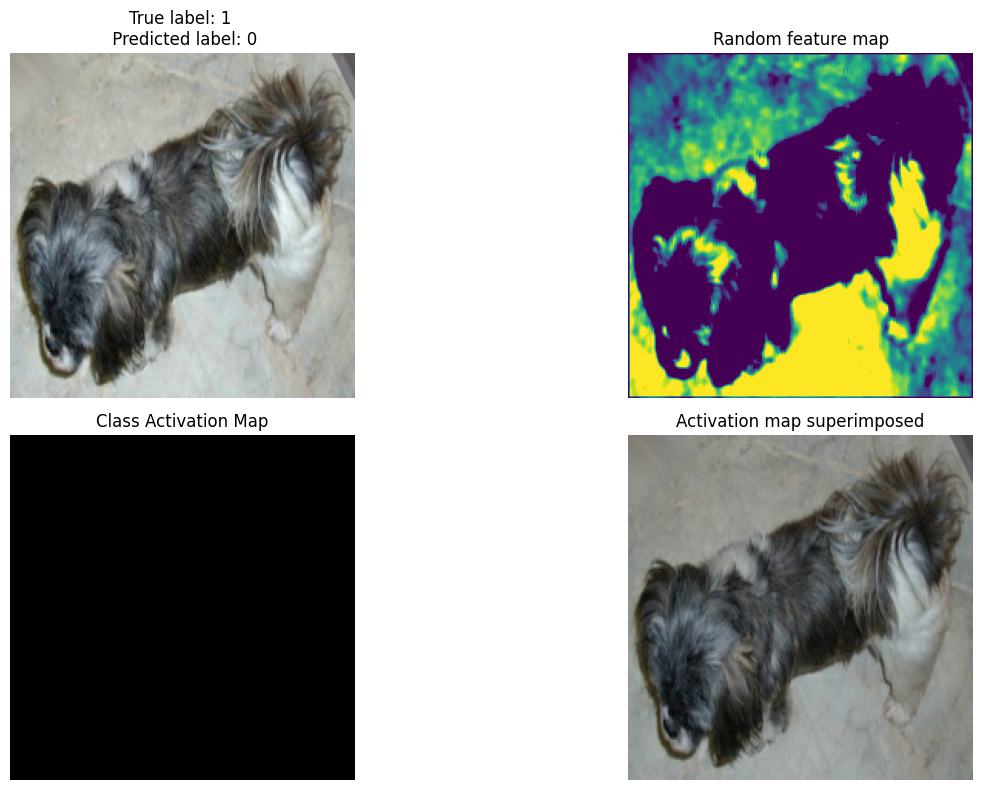

In [ ]:
# Choose an image index to show, or leave it as None to get a random image
activations = show_sample(idx=None)

### Intermediate activations of layers

We can use the utility function below to visualize the activations in the intermediate layers defined earlier. This function plots the features side by side for each convolution layer, starting from the earliest layer to the final convolution layer.

In [ ]:
def visualize_intermediate_activations(layer_names, activations):
    assert len(layer_names)==len(activations), "Make sure layers and activation values match"
    images_per_row=16

    for layer_name, layer_activation in zip(layer_names, activations):
        nb_features = layer_activation.shape[-1]
        size= layer_activation.shape[1]

        nb_cols = nb_features // images_per_row
        grid = np.zeros((size*nb_cols, size*images_per_row))

        for col in range(nb_cols):
            for row in range(images_per_row):
                feature_map = layer_activation[0,:,:,col*images_per_row + row]
                feature_map -= feature_map.mean()
                feature_map /= feature_map.std()
                feature_map *=255
                feature_map = np.clip(feature_map, 0, 255).astype(np.uint8)

                grid[col*size:(col+1)*size, row*size:(row+1)*size] = feature_map

        scale = 1./size
        plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(grid, aspect='auto', cmap='viridis')
    plt.show()

In [ ]:
# If we scroll down to the outputs of the final conv layer, we observe very few active features, primarily located in the cat's face.
# This region is what our model focuses on when determining the class.
visualize_intermediate_activations(activations=activations,
                                   layer_names=layer_names)